<a href="https://colab.research.google.com/github/itsmevidhyak/Trippy/blob/master/Stacking_simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stacking Simulations

In [2]:
# import packages
import collections
import matplotlib.pyplot as plt
from __future__ import print_function

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

try:
  tf.compat.v1.enable_eager_execution()
except ValueError:
  pass

**Objective**: To simulate a Poisson distribution with rate lambda, where lambda is sampled from Gamma distribution.

**Model Definition :**

$Outcome_i \sim Poisson(\lambda_i)$ <br>
$\lambda_i \sim Ga(\alpha, \beta)$

The samples we are drawing and storing in the variable simulated_values below are a tensor. Similarly, the .mean() method also returns a tensor. Matplotlib will throw an error if we try to pass this tensor directly into the plt.axvline() call. This is why we used the .numpy() method to extract the data value from the tensor.

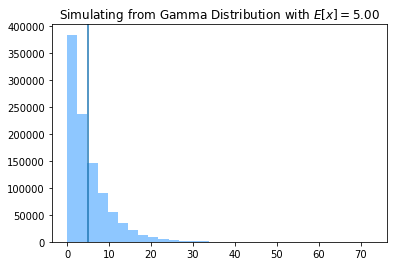

In [11]:
# Draw a Random variable from Gamma Distribution
rv_gamma = tfd.Gamma(concentration = 1.0, rate = 1.0 / 5.0)

# Sampling from the Gamma Distribution
simulated_values = rv_gamma.sample(1000000) 

# Plot the results
plt.hist(simulated_values, bins = 30, color = 'dodgerblue', alpha = 0.5)
plt.axvline(rv_gamma.mean().numpy())
plt.title('Simulating from Gamma Distribution with $E[x] = {:1.2f}$' .\
          format(rv_gamma.mean()))
plt.show()

We can see below that simulating a random draw independently from the Gamma distribution is unlikely to provide a lambda of exactly 5, which is the rate we defined for the Gamma distribution. If we draw many samples from the Gamma distribution, the lambda value likely will eventually converge to 5. Also, we would get a sense of the variability of this random variable.

This closely represents the real world. It is rare that we would know everything about our process. For example, we are all comfortable that people are different heights and if we randomly measured people, there would be variability in those measured heights. However, most of us (naively) assume that the mean value is a real, fixed, unvarying amount. 

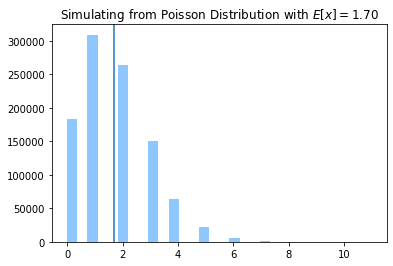

In [12]:
# Independently draw a lambda as a sample from above Gamma distribution
lambda_ = rv_gamma.sample()

# Draw a random variable from Poisson Distribution with rate Lambda
rv_poisson = tfd.Poisson(rate = lambda_)

# Sampling from the Poisson Distribution
simulated_values_poisson = rv_poisson.sample(1000000)

# Plot the results
plt.hist(simulated_values_poisson, bins = 30, color = 'dodgerblue', alpha = 0.5)
plt.axvline(lambda_.numpy())
plt.title('Simulating from Poisson Distribution with $E[x] = {:1.2f}$' .\
          format(lambda_))
plt.show()

Concretely, most people are happy to say that "people are of varying heights", but they would be less comfortable with the idea that "the average height" is also a varying quantity. In order to communicate clearly the reality, it is very important to convey **the uncertainty around the mean** as well. 

Think of a business intelligence dashboard and classic "analytics" where we report summary stats, like the mean. Very, very few business people would be comfortable with the idea that the mean itself has uncertainty associated with it.

Let's go back to our Poisson simulation and instead of drawing a single rate from rv_gamma, let's draw a range of rates from this distribution and pass all of these to our Poisson simulation. This way, we will get a better sense for the true variability.

We will have to adjust our Gamma distribution slightly so that it is centered more strongly around 5 (let us assume that the true rate is close to this value):

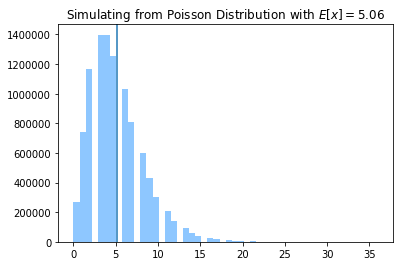

In [9]:
# Gamma random variable centred around 5
rv_gamma_new = tfd.Gamma(5., 1.)

# Independently draw lambdas as a sample from above Gamma distribution
lambdas_new = rv_gamma_new.sample(1000)

# Draw a random variable from Poisson Distribution with newly drawn lambdas 
rv_poisson_new = tfd.Poisson(lambdas_new)

# Sampling from the Poisson Distribution and store as a 1-d array for plotting
simulated_values_new = rv_poisson_new.sample(10000).numpy().ravel()

# Plot the results
plt.hist(simulated_values_new, bins = 50, color = 'dodgerblue', alpha = 0.5)
plt.axvline(rv_poisson_new.sample().numpy().mean())
plt.title('Simulating from Poisson Distribution with $E[x] = {:1.2f}$' .\
          format(rv_poisson_new.sample().numpy().mean()))
plt.show()

This is a truer picture of our "poisson process". Notice that we have a slightly higher amount of variability and values >10 are much more likely in this second simulation than they were in our first simulation. This is a very "real world" type of phenomenon.

**Unpacking 'Stacked Simulation**

The concept of "shape" is central to tensorflow and has been adopted by tensorflow probability. The shape of a tensor is determined by the length of each axes and tells us how many indices are available along each axes. It also tells us about the tensor's rank. Changing the shape changes the grouping of the elements within the tensor rather than the elements itself. 

When we sample from the gamma distribution, we get a tensor where shape = (n_samples,). Here is an example with 5 samples drawn from our gamma distribution:

In [13]:
# Draw 5 samples from rv_gamma_new random variable
rates = rv_gamma_new.sample(5)
rates

<tf.Tensor: id=416, shape=(5,), dtype=float32, numpy=
array([2.5614693, 2.8850033, 9.771803 , 5.0185657, 1.7392321],
      dtype=float32)>

Here is another example with 3 samples drawn from our poisson distribution we get a shape = (3, ):

In [14]:
# Draw 3 samples from rv_poisson_example random variable
rv_poisson_example = tfd.Poisson(rv_gamma_new.sample())
counts = rv_poisson_example.sample(3)
counts

<tf.Tensor: id=446, shape=(3,), dtype=float32, numpy=array([ 5., 10.,  4.], dtype=float32)>



Notice above, that I have reinstantiated the Poisson distribution with a single draw from the Gamma. This single draw has a shape of (1,) and when we pass this to our Poisson distribution, the result is that our Poisson distribution will have this shape.

If however, we pass in our rates which are of shape (5,), then our Poisson distribution will also have a shape of (5,). We can think of this as 5 separate Poisson distributions. Then, when we ask for 3 samples from our Poisson, we actually get 15 (3 samples from each of our 5 different Poissons):

In [19]:
rv_poisson_example2 = tfd.Poisson(rv_gamma_new.sample(5))
rv_poisson_example2

<tfp.distributions.Poisson 'Poisson/' batch_shape=[5] event_shape=[] dtype=float32>

In [20]:
counts_new = rv_poisson_example2.sample(3)
counts_new

<tf.Tensor: id=511, shape=(3, 5), dtype=float32, numpy=
array([[5., 8., 2., 7., 0.],
       [3., 3., 6., 7., 3.],
       [7., 9., 8., 5., 2.]], dtype=float32)>